In [3]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/smarcle_face_dataset/splitted"
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'val': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'val']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 3322, 'val': 953}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


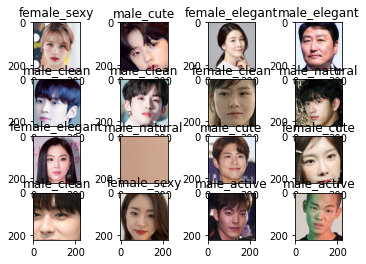

In [4]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

In [5]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(dataloaders['train']):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()
          
           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))
          
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['val']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)

In [ ]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=25)

visualize_model(vgg_based)

plt.show()

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.0245
train Loss: 0.0491
train Loss: 0.0739
train Loss: 0.0991
train Loss: 0.1233
train Loss: 0.1459
train Loss: 0.1690
train Loss: 0.1920
train Loss: 0.2152
train Loss: 0.2379
train Loss: 0.2632
train Loss: 0.2870
train Loss: 0.3113
train Loss: 0.3343
train Loss: 0.3580
train Loss: 0.3813
train Loss: 0.4037
train Loss: 0.4269
train Loss: 0.4470
train Loss: 0.4702
train Loss: 0.4928
train Loss: 0.5147
train Loss: 0.5347
train Loss: 0.5573
train Loss: 0.5773
train Loss: 0.5990
train Loss: 0.6202
train Loss: 0.6432
train Loss: 0.6654
train Loss: 0.6880
train Loss: 0.7094
train Loss: 0.7313
train Loss: 0.7506
train Loss: 0.7723
train Loss: 0.7928
train Loss: 0.8138
train Loss: 0.8338
train Loss: 0.8552
train Loss: 0.8761
train Loss: 0.8959
train Loss: 0.9163
train Loss: 0.9357
train Loss: 0.9554
train Loss: 0.9733
train Loss: 0.9952
train Loss: 1.0129
train Loss: 1.0321
train Loss: 1.0529
train Loss: 1.0749
train Loss: 1.0952
train Loss: 1.1154
train Loss: 1.1343
train Loss: 